# Activation Foil Analysis: 1L BABY Run #6

This notebook processes the calibration data from NaI detectors to energy calibrate the detectors and determine total detector efficiencies. Then, NaI measurements of activation foils irradiated during the run with a D-T neutron (14.1 MeV) generator are used to determine the average neutron rate during the run. 

## Obtaining the Data
First, the NaI detector measurement data is obtained from Zenodo and extracted

In [1]:
download_from_raw = True

In [2]:
import numpy as np
from datetime import datetime
import json

In [3]:

if download_from_raw:
    from download_raw_foil_data import check_source_measurements, background_meas
else:
    pass
    # read from local h5 with spectrum only

[{'t_on': 0.0, 't_off': 3600.0}]
Directory already exists: ../../data/neutron_detection/activation_foils
Processing Co60_1...
Processing Co60_2...
Processing Cs137_1...
Processing Cs137_2...
Processing Mn54_1...
Processing Mn54_2...
Processing Na22_1...
Processing Na22_2...
Processing background...


## Energy Calibration

Using gamma check sources like Co-60 and Cs-137, the characteristic photon peaks from these sources are used to convert the digitizer channel bins into energy (keV) bins

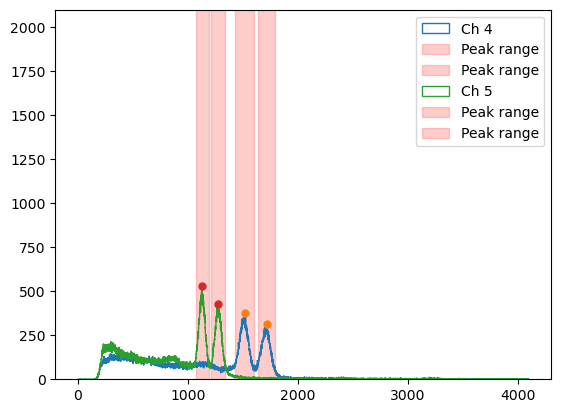

In [4]:
import matplotlib.pyplot as plt
from libra_toolbox.neutron_detection.activation_foils import compass

for detector in check_source_measurements["Co60_1"].detectors:
    hist, bin_edges = detector.get_energy_hist()

    plt.hist(
        bin_edges[:-1],
        bins=bin_edges,
        weights=hist,
        histtype="step",
        label=f"Ch {detector.channel_nb}",
    )
    peaks = check_source_measurements["Co60_1"].get_peaks(hist)
    # plt.plot(bin_edges[peaks], hist[peaks], '.', ms=10)

    from scipy.signal import find_peaks
    import numpy as np

    start_index = 400
    height = 0.60 * np.max(hist[start_index:])
    prominence = None
    width = [10, 150]
    distance = 30
    peaks, peak_data = find_peaks(
        hist[start_index:],
        prominence=prominence,
        height=height,
        width=width,
        distance=distance,
    )
    plt.plot(bin_edges[start_index:][peaks], peak_data["peak_heights"], ".", ms=10)

    for i, p in enumerate(peaks):
        width = peak_data["widths"][i]
        plt.axvspan(
            bin_edges[start_index:][p] - width,
            bin_edges[start_index:][p] + width,
            color="red",
            alpha=0.2,
            label="Peak range",
        )

plt.legend()
# plt.yscale("log")
plt.ylim(top=2100)
plt.show()

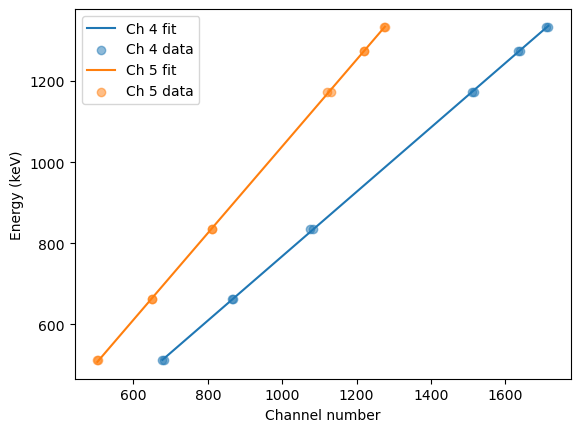

In [5]:
calibration_coeffs = {}

for channel_nb in [4, 5]:
    calibration_channels, calibration_energies = compass.get_calibration_data(
        check_source_measurements.values(),
        background_measurement=background_meas,
        channel_nb=channel_nb,
    )

    coeff = np.polyfit(calibration_channels, calibration_energies, 1)
    calibration_coeffs[channel_nb] = coeff

    xs = np.linspace(
        calibration_channels[0],
        calibration_channels[-1],
    )
    plt.plot(
        xs,
        np.polyval(coeff, xs),
        label=f"Ch {channel_nb} fit",
    )
    plt.scatter(
        calibration_channels,
        calibration_energies,
        label=f"Ch {channel_nb} data",
        alpha=0.5,
    )
plt.xlabel("Channel number")
plt.ylabel("Energy (keV)")
plt.legend()
plt.show()

## Detector Efficiency

Using these same check-sources, each with a known activity, an efficiency curve for each detector is calculated. 

Two types of efficiency curves are shown: 
1. Exponent of sum of logarithms (used in https://doi.org/10.2172/1524045): $ y = \exp(\sum_{i=0}^n a_n \log(E)^i) $

2. Polynomial fit (3rd order): $ y = \sum_{i=0}^n a_n E^i $

**Only the polynomal fit is currently implemented in libra-toolbox, so that is the curve that will be used to calculate the efficiency of the detectors at measuring the activity of the activation foil peaks.**

In [6]:
def eff_curve_func(E, *a):
    exponent_term = 0
    for i,a_n in enumerate(a):
        exponent_term += a_n * (np.log(E) ** i)
    return np.exp(exponent_term)

Ch 4 
	 Energies: [ 511.     511.     661.657  661.657  834.848  834.848 1173.228 1173.228
 1274.537 1274.537 1332.492 1332.492], 
	 Efficiencies: [0.02749373 0.02102159 0.0208609  0.01978268 0.01623395 0.01482226
 0.01069233 0.01022607 0.01084041 0.0114625  0.00938804 0.00976438]
[-401.53787468  179.77275958  -26.92278808    1.33491341]
Ch 5 
	 Energies: [ 511.     511.     661.657  661.657  834.848  834.848 1173.228 1173.228
 1274.537 1274.537 1332.492 1332.492], 
	 Efficiencies: [0.02787124 0.03575154 0.02642409 0.02780254 0.01975958 0.02142706
 0.01376862 0.01441652 0.01492938 0.01429497 0.01279407 0.01204011]
[-387.10142181  172.82997102  -25.79763533    1.27460871]


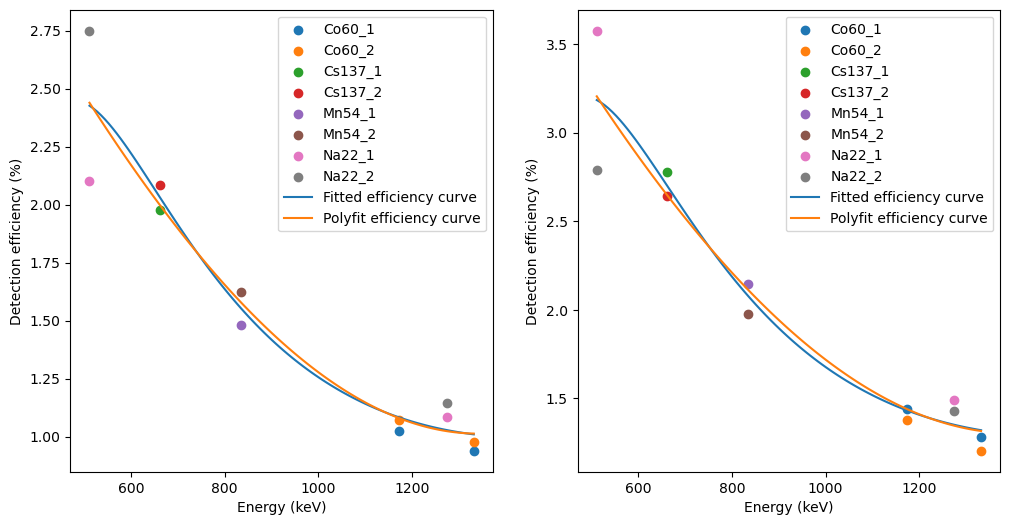

In [7]:
from scipy.optimize import curve_fit

channels = []
efficiency_coeffs = {}
measurement = list(check_source_measurements.values())[0]
search_widths = {4: 330, 5:330}

for detector in measurement.detectors:
    channels.append(detector.channel_nb)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i,ch in enumerate(channels):
    background_detector = background_meas.get_detector(ch)
    energies = []
    efficiencies = []
    for name, measurement in check_source_measurements.items():
        check_source_detector = measurement.get_detector(ch)
        hist, bin_edges = check_source_detector.get_energy_hist_background_substract(background_detector)
        calibrated_bin_edges = np.polyval(calibration_coeffs[ch], bin_edges)
        # fig, ax = plt.subplots()
        # ax.stairs(hist, calibrated_bin_edges)
        # ax.set_title(f'Ch {ch}: ' + name)
        # ax.set_yscale("symlog")

        # nb_counts_measured = compass.get_multipeak_area(
        #     hist,
        #     calibrated_bin_edges,
        #     measurement.check_source.nuclide.energy,
        #     search_width=search_widths[ch],
        # )
        # print(f"{name} - Ch {ch}: {nb_counts_measured} counts measured")
        
        efficiency = measurement.compute_detection_efficiency(
            background_measurement=background_meas,
            calibration_coeffs=calibration_coeffs[ch],
            channel_nb=ch,
            search_width=search_widths[ch],
        )
        energies += measurement.check_source.nuclide.energy
        efficiencies += list(efficiency)
        ax[i].scatter(
            measurement.check_source.nuclide.energy,
            efficiency * 100,
            label=name,
        )

    # Sort energies and efficiencies for fitting
    sorted_indices = np.argsort(energies)
    energies = np.array(energies)[sorted_indices]
    efficiencies = np.array(efficiencies)[sorted_indices]
    print(f"Ch {ch} \n\t Energies: {energies}, \n\t Efficiencies: {efficiencies}")

    # Fit the efficiency curve
    popt, pcov = curve_fit(
        eff_curve_func,
        energies,
        efficiencies,
        p0=[-1, 1, 0, 0],
    )

    poly_coeff = np.polyfit(energies, efficiencies, 3)
    efficiency_coeffs[ch] = poly_coeff
    xs = np.linspace(
        energies[0],
        energies[-1],
        100,
    )
    ax[i].plot(
        xs,
        eff_curve_func(xs, *popt) * 100,
        label="Fitted efficiency curve",
    )

    ax[i].plot(
        xs,
        np.polyval(poly_coeff, xs) * 100,
        label="Polyfit efficiency curve",
    )
    ax[i].set_xlabel("Energy (keV)")
    ax[i].set_ylabel("Detection efficiency (%)")
    ax[i].legend()
    # plt.ylim(bottom=0)
    print(popt)
plt.show()

## Calculating average neutron rate from activation foils

First, the irradiation schedule and the foil information like its mass and thickness are collected.

In [8]:
all_neutron_rates = []
all_neutron_rates_err = []

In [9]:
from temp import get_foil

In [10]:
niobium3, niobium3_distance_to_source = get_foil("Nb")

Read in properties of Nb Packet #3 foil


### Niobium Packet #3 Results

The activity of Nb-92m is measured using its 934 keV gamma peak and used to determine the neutron rate during the irradiation. Nb-92m is formed from the Nb-93(n,2n) reaction, which has a threshold energy of 8.9 MeV. 

The gamma spectrum obtained from the 1st measurement of the Niobium Packet #3 after irradiation is used to calculate the neutron rate of the overall irradiation. 

In [12]:
from libra_toolbox.neutron_detection.activation_foils.compass import (
    Measurement,
    CheckSourceMeasurement,
    SampleMeasurement,
)

from temp import measurement_directory, irradiations, time_generator_off

niobium3_measurement1 = SampleMeasurement.from_directory(
    source_dir= measurement_directory / "Niobium3_20250601_1358_count1/UNFILTERED",
    name="Niobium3_count1")
niobium3_measurement1.foil = niobium3


for detector in niobium3_measurement1.detectors:
    ch = detector.channel_nb

    gamma_emitted, gamma_emitted_err = niobium3_measurement1.get_gamma_emitted(
        background_measurement=background_meas,
        calibration_coeffs=calibration_coeffs[ch],
        efficiency_coeffs=efficiency_coeffs[ch],
        channel_nb=ch,
        search_width=330)
    
    neutron_rate = niobium3_measurement1.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted,
        irradiations=irradiations,
        distance=niobium3_distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=niobium3.reaction.product.intensity
    )

    neutron_rate_err = niobium3_measurement1.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted_err,
        irradiations=irradiations,
        distance=niobium3_distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=niobium3.reaction.product.intensity
    )
    print(f"Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s, \n\t Gamma emitted: {gamma_emitted} ± {gamma_emitted_err} counts")
    all_neutron_rates.append(neutron_rate[0])
    all_neutron_rates_err.append(neutron_rate_err[0])


Ch 4: Neutron rate: 1.400e+09 +/- 1.161e+07 n/s, 
	 Gamma emitted: [1050116.48781304] ± [8708.79340766] counts
Ch 5: Neutron rate: 1.345e+09 +/- 9.816e+06 n/s, 
	 Gamma emitted: [1009286.87951658] ± [7365.93611718] counts


The gamma spectrum obtained from 2nd measurement of the Niobium Packet #3 after irradiation is used to calculate the neutron rate of the overall irradiation. 

In [13]:
niobium3_measurement2 = SampleMeasurement.from_directory(
    source_dir= measurement_directory / "Niobium3_20250602_1123_count2/UNFILTERED",
    name="Niobium3_count1")
niobium3_measurement2.foil = niobium3


for detector in niobium3_measurement2.detectors:
    ch = detector.channel_nb

    gamma_emitted, gamma_emitted_err = niobium3_measurement2.get_gamma_emitted(
        background_measurement=background_meas,
        calibration_coeffs=calibration_coeffs[ch],
        efficiency_coeffs=efficiency_coeffs[ch],
        channel_nb=ch,
        search_width=330)
    
    neutron_rate = niobium3_measurement2.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted,
        irradiations=irradiations,
        distance=niobium3_distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=niobium3.reaction.product.intensity
    )

    neutron_rate_err = niobium3_measurement2.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted_err,
        irradiations=irradiations,
        distance=niobium3_distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=niobium3.reaction.product.intensity
    )
    print(f"Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s, \n\t Gamma emitted: {gamma_emitted} ± {gamma_emitted_err} counts")
    all_neutron_rates.append(neutron_rate[0])
    all_neutron_rates_err.append(neutron_rate_err[0])

Ch 5: Neutron rate: 1.450e+09 +/- 1.496e+07 n/s, 
	 Gamma emitted: [505024.98405759] ± [5210.47199522] counts
Ch 4: Neutron rate: 1.384e+09 +/- 1.695e+07 n/s, 
	 Gamma emitted: [481750.31193767] ± [5898.61772897] counts


### Zirconium Packet #1 Results

The activity of Zr-89 is measured using its 909 keV gamma peak and used to determine the neutron rate during the irradiation. Zr-89 m is formed from the Zr-90(n,2n) reaction, which has a threshold energy of 12.1 MeV. 

The gamma spectrum obtained from the 1st measurement of the Zirconium Packet #1 after irradiation is used to calculate the neutron rate of the overall irradiation. 

In [14]:
zirconium1, zirconium1_distance_to_source = get_foil("Zr")

Read in properties of Zr Packet #1 foil


In [15]:
zirconium1_measurement1 = SampleMeasurement.from_directory(
    source_dir= measurement_directory / "Zirconium1_20250530_1512_count1/UNFILTERED",
    name="Zirconium1_count1")
zirconium1_measurement1.foil = zirconium1


for detector in zirconium1_measurement1.detectors:
    ch = detector.channel_nb

    gamma_emitted, gamma_emitted_err = zirconium1_measurement1.get_gamma_emitted(
        background_measurement=background_meas,
        calibration_coeffs=calibration_coeffs[ch],
        efficiency_coeffs=efficiency_coeffs[ch],
        channel_nb=ch,
        search_width=330)
    
    neutron_rate = zirconium1_measurement1.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted,
        irradiations=irradiations,
        distance=zirconium1_distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=zirconium1.reaction.product.intensity
    )

    neutron_rate_err = zirconium1_measurement1.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted_err,
        irradiations=irradiations,
        distance=zirconium1_distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=zirconium1.reaction.product.intensity
    )
    print(f"Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s, \n\t Gamma emitted: {gamma_emitted} ± {gamma_emitted_err} counts")
    all_neutron_rates.append(neutron_rate[0])
    all_neutron_rates_err.append(neutron_rate_err[0])

Ch 4: Neutron rate: 1.207e+09 +/- 5.711e+06 n/s, 
	 Gamma emitted: [3124934.98190289] ± [14781.25308837] counts
Ch 5: Neutron rate: 1.182e+09 +/- 4.875e+06 n/s, 
	 Gamma emitted: [3061586.32556969] ± [12627.82325915] counts


The gamma spectrum obtained from the 2nd measurement of the Zirconium Packet #1 after irradiation is used to calculate the neutron rate of the overall irradiation. 

In [16]:
zirconium1_measurement2 = SampleMeasurement.from_directory(
    source_dir= measurement_directory / "Zirconium1_20250531_2115_count2/UNFILTERED",
    name="Zirconium1_count2")
zirconium1_measurement2.foil = zirconium1


for detector in zirconium1_measurement2.detectors:
    ch = detector.channel_nb

    gamma_emitted, gamma_emitted_err = zirconium1_measurement2.get_gamma_emitted(
        background_measurement=background_meas,
        calibration_coeffs=calibration_coeffs[ch],
        efficiency_coeffs=efficiency_coeffs[ch],
        channel_nb=ch,
        search_width=330)
    
    neutron_rate = zirconium1_measurement2.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted,
        irradiations=irradiations,
        distance=zirconium1_distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=zirconium1.reaction.product.intensity
    )

    neutron_rate_err = zirconium1_measurement2.get_neutron_rate(
        channel_nb=ch,
        photon_counts=gamma_emitted_err,
        irradiations=irradiations,
        distance=zirconium1_distance_to_source,
        time_generator_off=time_generator_off,
        branching_ratio=zirconium1.reaction.product.intensity
    )
    print(f"Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s, \n\t Gamma emitted: {gamma_emitted} ± {gamma_emitted_err} counts")
    all_neutron_rates.append(neutron_rate[0])
    all_neutron_rates_err.append(neutron_rate_err[0])

Ch 5: Neutron rate: 1.178e+09 +/- 5.557e+06 n/s, 
	 Gamma emitted: [2338597.89086799] ± [11036.54191261] counts
Ch 4: Neutron rate: 1.186e+09 +/- 6.462e+06 n/s, 
	 Gamma emitted: [2354648.15449206] ± [12830.80105014] counts


### Averaging foil results

The average of the neutron rates of the Niobium and Zirconium foil packets is calculated and added to the processed_data.json file. 

In [17]:
average_neutron_rate = np.mean(all_neutron_rates)
# average_neutron_rate_err = np.sqrt(np.sum(np.array(all_neutron_rates_err) ** 2)) / len(all_neutron_rates_err)
average_neutron_rate_err = np.std(all_neutron_rates, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Average neutron rate: {average_neutron_rate:.3e} ± {average_neutron_rate_err:.3e} n/s")

Average neutron rate: 1.291e+09 ± 1.144e+08 n/s


In [18]:
processed_data_file = "../../data/processed_data.json"

processed_data = {
    "neutron_rate_used_in_model": {
        "value":average_neutron_rate,
        "error": average_neutron_rate_err,
        "unit": "neutron / second"
    }
}

try:
    with open(processed_data_file, "r") as f:
        existing_data = json.load(f)
except FileNotFoundError:
    print(f"Processed data file not found, creating it in {processed_data_file}")
    existing_data = {}

existing_data.update(processed_data)

with open(processed_data_file, "w") as f:
    json.dump(existing_data, f, indent=4)

print(f"Processed data stored in {processed_data_file}")

Processed data stored in ../../data/processed_data.json
